In [4]:
%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
%autoreload 2

from IPython import display

In [6]:
# code copy pasted from PyCharm

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import collections

from utils import Logger

In [11]:
def mnist_data():
    compose = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((.5, .5, .5), (.5, .5, .5))])
    out_dir = './dataset'
    return datasets.MNIST(root=out_dir, train=True, transform=transforms.ToTensor(), download=True)


data = mnist_data()
print(len(data))

# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
len(data_loader)

60000


600

In [12]:
data[1]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

60000
True
GeneratorNet(
  (hidden0): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden1): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden2): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (out): Sequential(
    (0): Linear(in_features=1024, out_features=784, bias=True)
    (1): Tanh()
  )
)


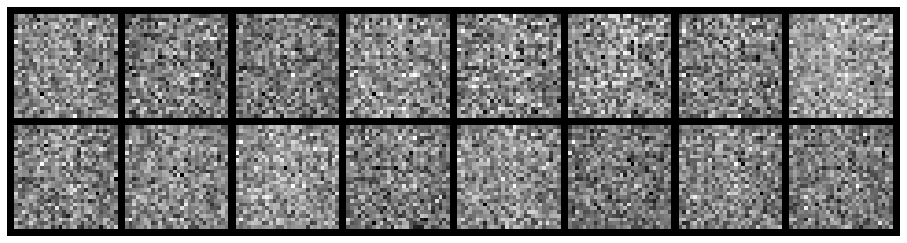

Epoch: [0/200], Batch Num: [0/600]
Discriminator Loss: 1.3843, Generator Loss: 0.6673
D(x): 0.5154, D(G(z)): 0.5140


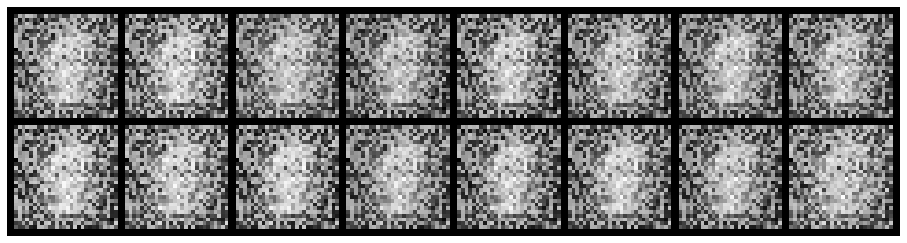

Epoch: [0/200], Batch Num: [100/600]
Discriminator Loss: 1.8322, Generator Loss: 1.3439
D(x): 0.2377, D(G(z)): 0.2995


KeyboardInterrupt: 

In [3]:
# Num batches
num_batches = len(data_loader)

# is data_loader iterable?
print(isinstance(data_loader, collections.Iterable))


# Discriminator
# input: flattened image 28x28
# returns: probability of belonging to the real or synthetic dataset
# hidden layers = 3
# Leaky ReLU
# Dropout layer
class DiscriminatorNet(torch.nn.Module):
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1

        # A three hidden-layer discriminative neural network
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x


discriminator = DiscriminatorNet()


# convert flattened image to 2D
def images_to_vectors(images):
    return images.view(images.size(0), 784)


def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)


# input: latent variable vector
# return: 784 values vector (28x28)
# hidden layers: 3
# Leaky-ReLU
# output layer: tanH
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """

    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784

        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )

        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x


generator = GeneratorNet()
print(generator)


# create random noise. Normal distribution
# mean = 0
# sd = 1
def noise(size):
    """
    Generates a 1-d vector of gaussian sampled random values
    """
    n = Variable(torch.randn(size, 100))
    return n


# optimization algorithm for both neural networks: Adam
# learning rate = 0.0002
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# loss function
# resembles the log-loss for both the Generator and Discriminator
loss = nn.BCELoss()


# targets
def ones_target(size):
    """
    Tensor containing ones, with shape = size. Real
    """
    data = Variable(torch.ones(size, 1))
    return data


def zeros_target(size):
    """
    Tensor containing zeros, with shape = size. Fake
    """
    data = Variable(torch.zeros(size, 1))
    return data


def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()

    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and back-propagate
    error_real = loss(prediction_real, ones_target(N))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and back-propagate
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()

    # 1.3 Update weights with gradients
    optimizer.step()

    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake


def train_generator(optimizer, fake_data):
    N = fake_data.size(0)    # Reset gradients
    optimizer.zero_grad()    # Sample noise and generate fake data
    prediction = discriminator(fake_data)    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N))
    error.backward()    # Update weights with gradients
    optimizer.step()    # Return error
    return error


num_test_samples = 16
test_noise = noise(num_test_samples)

# Total number of epochs to train
num_epochs = 200

logger = Logger(model_name='VGAN', data_name='MNIST')


for epoch in range(num_epochs):
    for n_batch, (real_batch, _) in enumerate(data_loader):
        N = real_batch.size(0)

        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))

        # Generate fake data and detach
        # (so gradients are not calculated for generator)
        fake_data = generator(noise(N)).detach()

        # Train D
        d_error, d_pred_real, d_pred_fake = \
            train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator
      
        # Generate fake data
        fake_data = generator(noise(N))

        # Train G
        g_error = train_generator(g_optimizer, fake_data)

        # Log batch error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)

        # Display Progress every few batches
        if n_batch % 100 == 0:
            test_images = vectors_to_images(generator(test_noise))
            test_images = test_images.data

            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches)

            # Display status Logs
            logger.display_status(epoch, num_epochs, n_batch, num_batches,
                                  d_error, g_error, d_pred_real, d_pred_fake)
